In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

df = pd.read_csv('bank_transactions_data_2.csv')

print(df.head())
print(df.info())

print(df.isnull().sum())


  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81 

In [ ]:
# Fill missing values for numeric columns only
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Encode categorical features
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Select relevant features, EXCLUDING DeviceID and IP Address
features = df[['TransactionAmount', 'TransactionDuration', 'LoginAttempts',
               'AccountBalance', 'CustomerAge']] # Removed DeviceID and IP Address

# Standardize numerical features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['Anomaly_IF'] = isolation_forest.fit_predict(features_scaled)

# Map the predictions: -1 for anomalies, 1 for normal
df['Anomaly_IF'] = df['Anomaly_IF'].map({1: 0, -1: 1})

# Count of fraudulent transactions
print(df['Anomaly_IF'].value_counts())


Anomaly_IF
0    2386
1     126
Name: count, dtype: int64


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['Anomaly_LOF'] = lof.fit_predict(features_scaled)

# Map the predictions: -1 for anomalies, 1 for normal
df['Anomaly_LOF'] = df['Anomaly_LOF'].map({1: 0, -1: 1})

# Count of fraudulent transactions
print(df['Anomaly_LOF'].value_counts())


Anomaly_LOF
0    2386
1     126
Name: count, dtype: int64


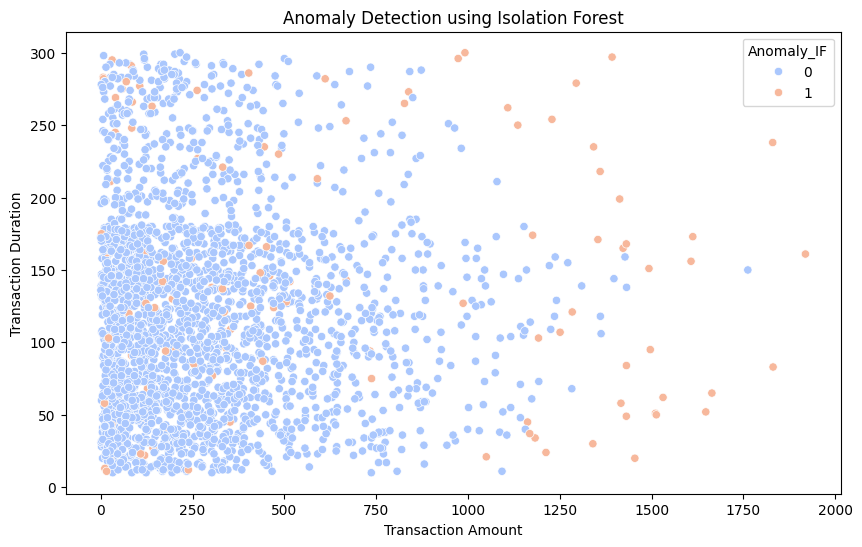

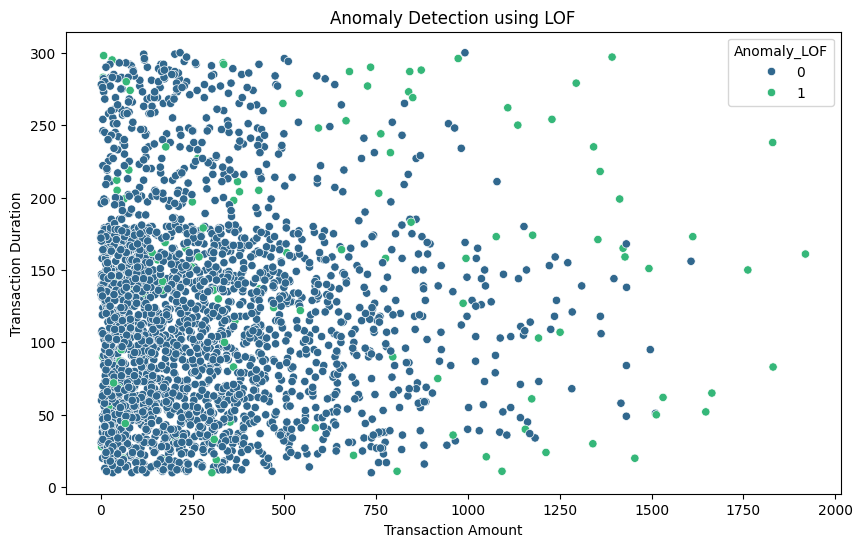

In [ ]:
# Scatter plot for Isolation Forest results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['TransactionAmount'], y=df['TransactionDuration'], hue=df['Anomaly_IF'], palette='coolwarm')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Duration')
plt.show()

# Scatter plot for Local Outlier Factor results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['TransactionAmount'], y=df['TransactionDuration'], hue=df['Anomaly_LOF'], palette='viridis')
plt.title('Anomaly Detection using LOF')
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Duration')
plt.show()


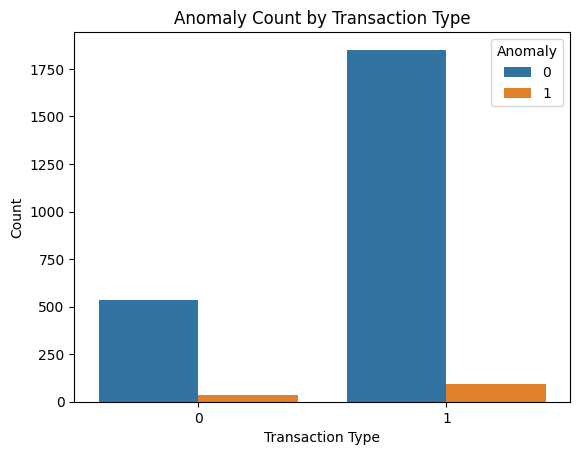

In [ ]:
# Count anomalies by transaction type
sns.countplot(x='TransactionType', hue='Anomaly_IF', data=df) # Changed 'Anomaly_IsolationForest' to 'Anomaly_IF'
plt.title('Anomaly Count by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='Anomaly')
plt.show()

In [ ]:
# Analyze flagged anomalies
anomalies_if = df[df['Anomaly_IF'] == 1]
anomalies_lof = df[df['Anomaly_LOF'] == 1]

print("Isolation Forest Anomalies:")
print(anomalies_if.describe())

print("Local Outlier Factor Anomalies:")
print(anomalies_lof.describe())


Isolation Forest Anomalies:
       TransactionAmount  TransactionType    Location     Channel  \
count         126.000000       126.000000  126.000000  126.000000   
mean          608.634127         0.738095   21.539683    0.952381   
std           568.252482         0.441426   11.383954    0.818361   
min             1.930000         0.000000    0.000000    0.000000   
25%           120.177500         0.000000   12.250000    0.000000   
50%           378.300000         1.000000   20.000000    1.000000   
75%          1174.275000         1.000000   30.000000    2.000000   
max          1919.110000         1.000000   42.000000    2.000000   

       CustomerAge  CustomerOccupation  TransactionDuration  LoginAttempts  \
count   126.000000          126.000000           126.000000     126.000000   
mean     46.039683            1.325397           146.428571       3.007937   
std      19.534339            1.151204            85.416292       1.637051   
min      18.000000            0.000000

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build an autoencoder
input_dim = features_scaled.shape[1]
autoencoder = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='linear')
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(features_scaled, features_scaled, epochs=50, batch_size=32, shuffle=True)

# Get reconstruction errors
reconstructions = autoencoder.predict(features_scaled)
mse = np.mean(np.power(features_scaled - reconstructions, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 95)  # Top 5% as anomalies
df['Anomaly_Autoencoder'] = (mse > threshold).astype(int)

# Visualize results
print(df['Anomaly_Autoencoder'].value_counts())


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8787
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4197
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1458
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0530
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 16/50
79/79 ━━━━━━━━━━━━